In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.models import Sequential
plt.style.use("fivethirtyeight")

In [2]:
churn_data = pd.read_csv('/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)

sc = MinMaxScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

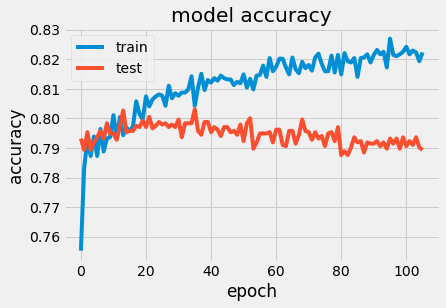

In [3]:
# Model 1
nn_model = Sequential()
nn_model.add(Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.001), input_dim=46, activation='relu' ))
nn_model.add(Dropout(rate=0.2))
nn_model.add(Dense(8,kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='relu'))
nn_model.add(Dropout(rate=0.1))
nn_model.add(Dense(1, activation='sigmoid'))
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( 0.001,
      decay_steps=(X_train.shape[0]/32)*50,
      decay_rate=1,
      staircase=False)
#This time decay means for every 50 epochs the learning rate will be half of 0.001 value
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=70,restore_best_weights=True)]
nn_model.compile(loss = "binary_crossentropy",
                  optimizer = get_optimizer(),
                  metrics=['accuracy'])


history = nn_model.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=150, batch_size=32,   callbacks=get_callbacks(),verbose=0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
yprednn=nn_model.predict(X_test_sc)
yprednn=yprednn.round()
print('Neural Network:\n {}\n'.format(
    metrics.classification_report(yprednn, y_test)))
nn_conf_matrix=metrics.confusion_matrix(yprednn,y_test)
conf_mat_nn = pd.DataFrame(nn_conf_matrix,
    columns=["Predicted NO", "Predicted YES"],
    index=["Actual NO", "Actual YES"])
print(conf_mat_nn)


Neural Network:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1826
         1.0       0.53      0.65      0.59       495

    accuracy                           0.80      2321
   macro avg       0.72      0.75      0.73      2321
weighted avg       0.82      0.80      0.81      2321


            Predicted NO  Predicted YES
Actual NO           1540            286
Actual YES           171            324


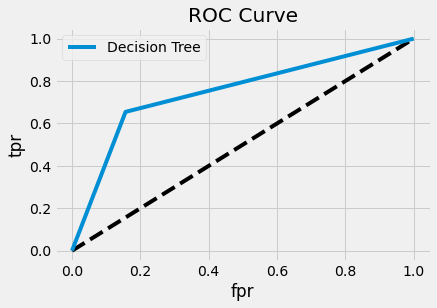

In [5]:
fpr, tpr, threshold = metrics.roc_curve(yprednn, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'Decision Tree')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();

